In [ ]:
from flyanalysis.braidz import read_braidz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [191]:
def read_files(files):
    data = {}

    for file in tqdm(files):
        df, csvs = read_braidz("/home/buchsbaum/mnt/md0/Experiments/" + file)
        data[file] = {}
        data[file]["df"] = df
        data[file]["stim"] = csvs["stim"]

    return data

def get_velocities(data):
    angular_velocities = []
    linear_velocities = []

    for file, data in data.items():
        df = data["df"]
        stim = data["stim"]

        for idx, row in stim.iterrows():
            obj_id = int(row["obj_id"])
            frame = int(row["frame"])

            grp = df[df["obj_id"] == obj_id]
            try:
                stim_idx = np.where(grp["frame"] == frame)[0][0]
            except IndexError:
                continue

            start_idx = stim_idx - 50
            end_idx = stim_idx + 100

            if start_idx < 0 or end_idx >= len(grp):
                continue

            theta = np.arctan2(grp.yvel.values, grp.xvel.values)
            theta_unwrap = np.unwrap(theta)
            angular_velocity = np.gradient(theta_unwrap, 0.01)

            linear_velocity = np.sqrt(grp.xvel.values**2 + grp.yvel.values**2 + grp.zvel.values**2)
            
            angular_velocities.append(angular_velocity[start_idx:end_idx])
            linear_velocities.append(linear_velocity[start_idx:end_idx])

    return np.array(angular_velocities), np.array(linear_velocities)

In [192]:
ax_files = ["20230113_163446.braidz","20230116_124945.braidz","20230203_145747.braidz","20230512_144203.braidz"]
ax_data = read_files(ax_files)

  0%|          | 0/4 [00:00<?, ?it/s]

Reading /home/buchsbaum/mnt/md0/Experiments/20230113_163446.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20230116_124945.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20230203_145747.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20230512_144203.braidz using pyarrow


In [193]:
angvel, linvel = get_velocities(ax_data)

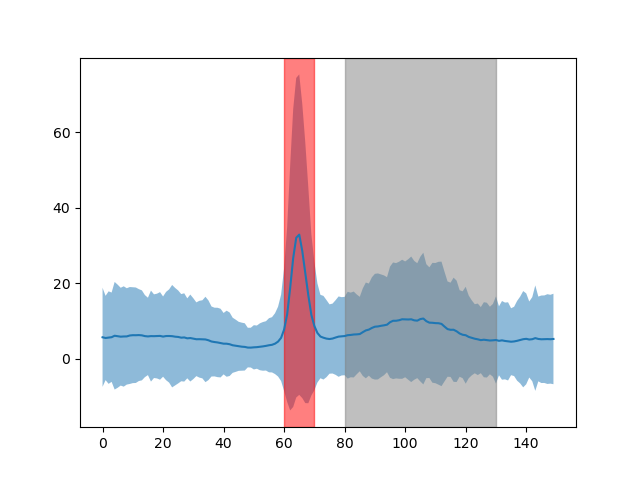

In [241]:
fig = plt.figure()
mean = np.nanmean(np.abs(angvel), axis=0)
std = np.nanstd(np.abs(angvel), axis=0)
plt.plot(mean)
plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.5)
plt.axvspan(60, 70, alpha=0.5, color="red")
plt.axvspan(80, 130, alpha=0.5, color="gray")
plt.show()

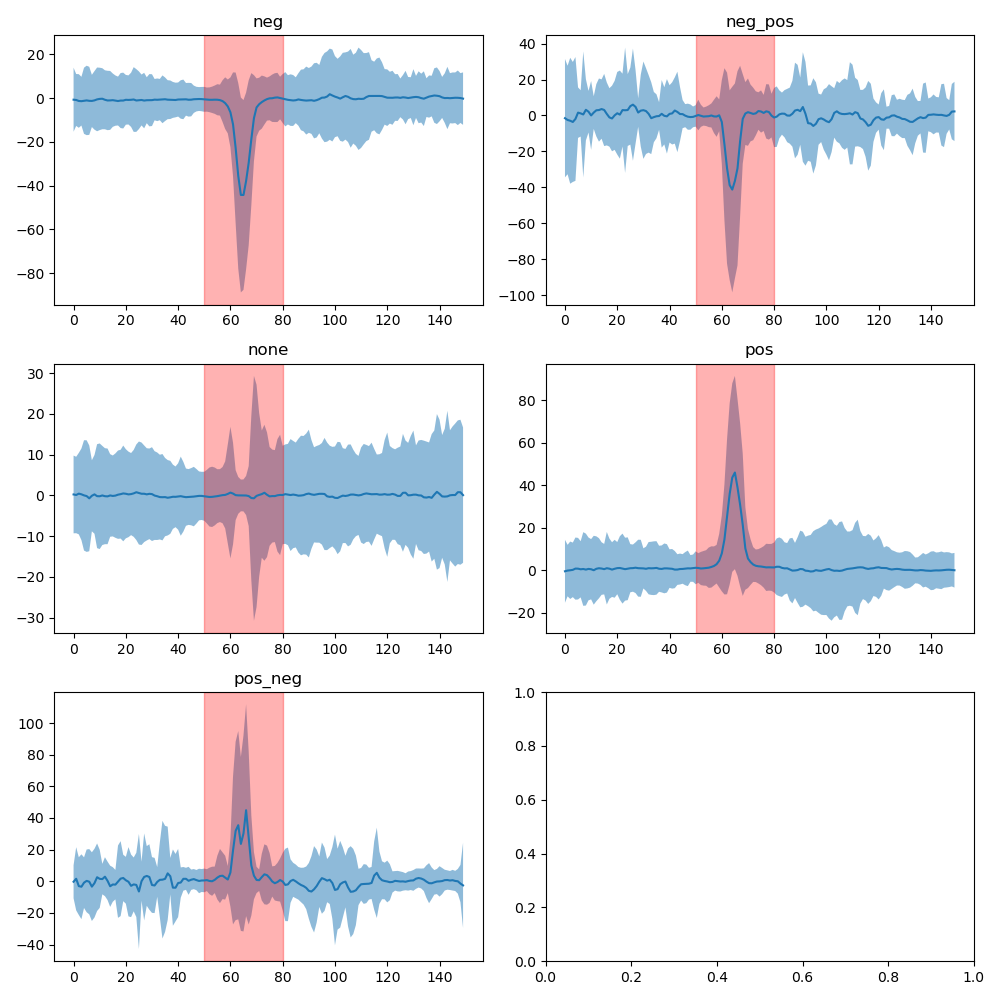

(array(['neg', 'neg_pos', 'none', 'pos', 'pos_neg'], dtype='<U7'), array([1165,   95,  951, 1054,   54]))


In [242]:
def categorize_trajectories(trajectories, threshold, first_turn_start=60, first_turn_end=70, second_turn_start=80, second_turn_end=130):
    n_trajectories = trajectories.shape[0]
    categories = []

    for i in range(n_trajectories):
        trajectory = trajectories[i]
        
        # get turns
        primary_turn = trajectory[first_turn_start:first_turn_end]
        secondary_turn = trajectory[second_turn_start:second_turn_end]

        if np.max(primary_turn) > np.max(-primary_turn)
    return categories


def plot_category(data, category, categories, ax):
    filter_idx = np.array([cat == category for cat in categories])
    mean = np.nanmean(data[filter_idx], axis=0)
    std = np.nanstd(data[filter_idx], axis=0)
    ax.plot(mean)
    ax.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.5)
    
    # fill area between 50-80 frames with red square
    ax.axvspan(50, 80, color='red', alpha=0.3)

threshold = np.deg2rad(300)
categories = categorize_trajectories(angvel, threshold)

plt.close('all')
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))
for ax, cat in zip(axs.flatten(), np.unique(categories)):
    plot_category(angvel, cat, categories, ax)
    ax.set_title(cat)
    
plt.tight_layout()
plt.show()

# print number of trajectories in each category
print(np.unique(categories, return_counts=True))


array([[-3.91331263e+00, -3.09804108e+00,  3.12920982e-02, ...,
         5.09950757e+00,  1.08838653e+01,  8.15802359e+00],
       [ 7.10112155e-01,  3.66622636e+00,  4.49943564e+00, ...,
         6.25194472e-01, -3.82575859e-01,  3.58280416e-02],
       [-3.13241592e+01, -2.29617557e+01, -1.32094334e+01, ...,
         4.89576034e+00,  4.38910882e+00, -1.10154574e+01],
       ...,
       [-1.40452942e+02,  4.15215496e+01,  7.10868476e+00, ...,
         1.24597639e+02,  8.85360359e+01,  2.75888057e+01],
       [ 3.97694076e+00, -1.11599012e+01,  1.83056056e+01, ...,
         1.17319336e+01,  1.26172676e+02,  1.29075383e+02],
       [-2.30486982e+02, -2.27825673e+02, -1.75093257e+02, ...,
         2.96970030e+00,  1.88910673e+00, -7.77630084e-01]])

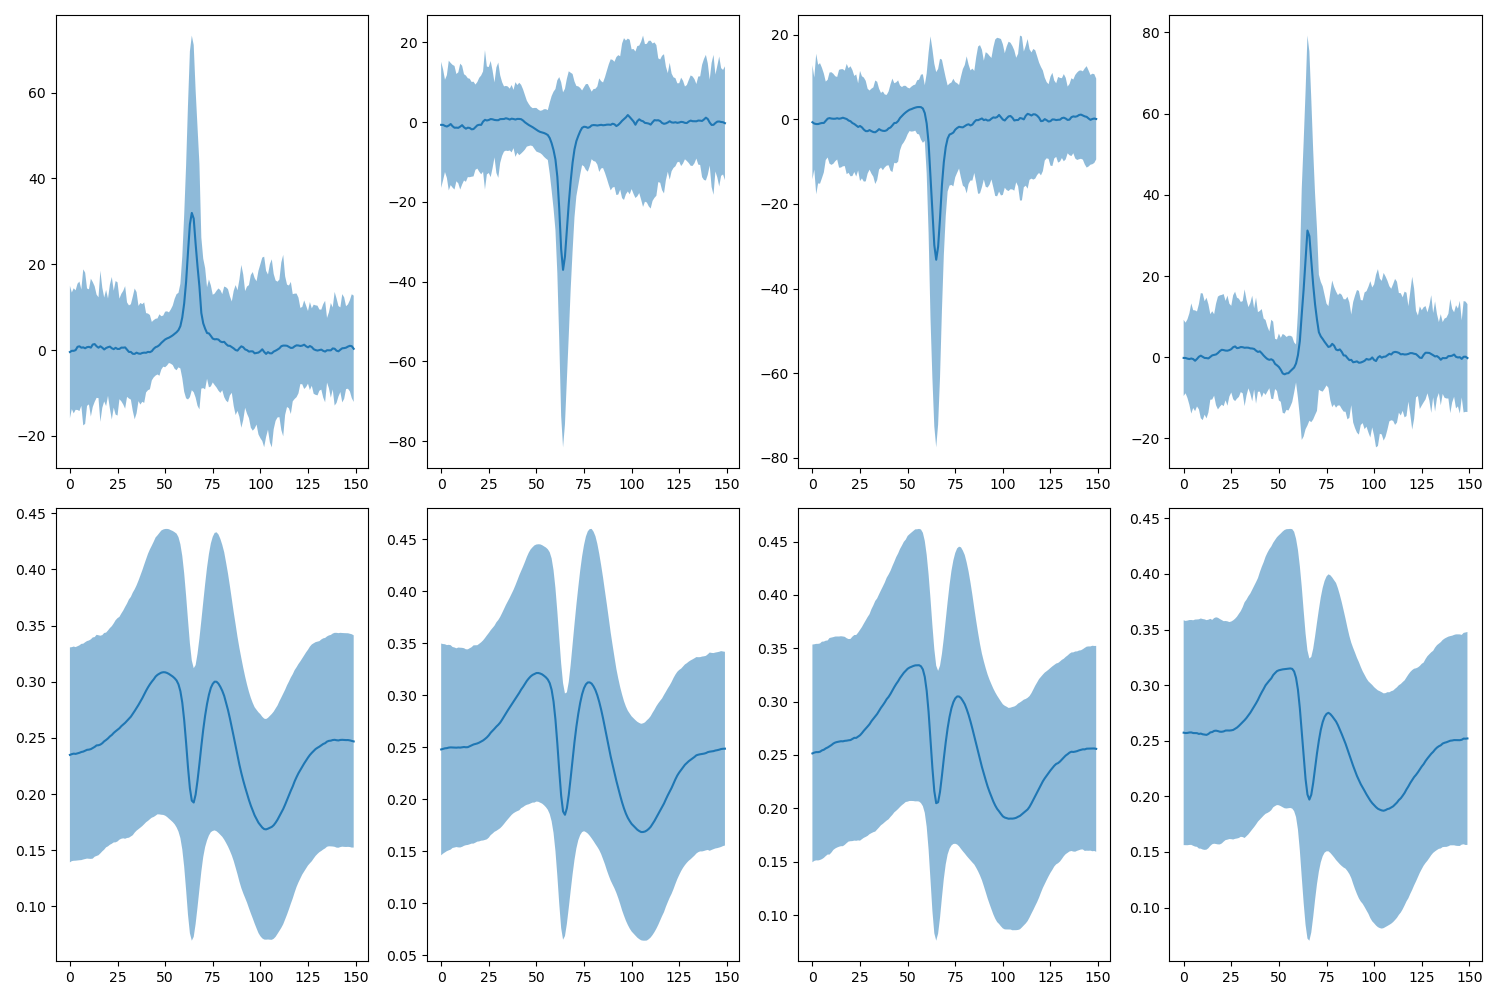

In [197]:
mosaic = [["a1", "b1", "c1", "d1"],
          ["a2", "b2", "c2", "d2"]]

fig, axs = plt.subplot_mosaic(mosaic, figsize=(15,10))

plot_category(angvel, "pos_pos", categories, axs["a1"])
plot_category(angvel, "neg_neg", categories, axs["b1"])
plot_category(angvel, "pos_neg", categories, axs["c1"])
plot_category(angvel, "neg_pos", categories, axs["d1"])

plot_category(linvel, "pos_pos", categories, axs["a2"])
plot_category(linvel, "neg_neg", categories, axs["b2"])
plot_category(linvel, "pos_neg", categories, axs["c2"])
plot_category(linvel, "neg_pos", categories, axs["d2"])

plt.tight_layout()
plt.show()